# Baseline Model Training v3 - Enhanced Features

Improvements over v2:
1. **Holiday features**: German public holidays and school holiday indicators
2. **Season ticket data**: Include season_tickets_sold as trend proxy
3. **Derived features**: avg_ticket_price, spieltag, days_to_season_end
4. **Cyclical encoding**: sin/cos transformation for month and weekday
5. **Hyperparameter tuning**: GridSearchCV for tree-based models
6. **Better evaluation**: MAPE metric and error analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import holidays
import warnings
warnings.filterwarnings('ignore')

## 1. Load Data

In [2]:
# Load original data with all columns
df = pd.read_csv('Data/data_v1/grizzlys_combined_schedule_sales_v3.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = pd.to_datetime(df['date'])

print(f"Total samples: {len(df)}")
print(f"\nColumns available: {list(df.columns)}")
print(f"\nSeasons: {df['season'].unique()}")
print(f"\nTicket count range: {df['ticket_count'].min():.0f} - {df['ticket_count'].max():.0f}")

Total samples: 77

Columns available: ['spieltag', 'date', 'weekday', 'time', 'home_team', 'away_team', 'distance', 'season', 'datetime', 'ticket_count', 'gross_revenue', 'season_tickets_sold', 'season_tickets_revenue', 'total_season_tickets', 'total_season_revenue']

Seasons: ['22-23' '23-24' '24-25']

Ticket count range: 252 - 3492


## 2. Feature Engineering

In [3]:
# Create a copy for feature engineering
data = df.copy()

# Basic time features
data['month'] = data['datetime'].dt.month
data['weekday'] = data['datetime'].dt.weekday  # 0=Monday, 6=Sunday
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour + data['datetime'].dt.minute/60

# Weekend indicator
data['is_weekend'] = (data['weekday'] >= 5).astype(int)

# Spieltag (matchday number) - already in data
data['spieltag'] = data['spieltag']

print("Basic time features added")

Basic time features added


In [4]:
# Cyclical encoding for month and weekday
# This helps models understand that December (12) is close to January (1)

data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

data['weekday_sin'] = np.sin(2 * np.pi * data['weekday'] / 7)
data['weekday_cos'] = np.cos(2 * np.pi * data['weekday'] / 7)

print("Cyclical encoding added for month and weekday")

Cyclical encoding added for month and weekday


In [5]:
# Holiday features
german_holidays = holidays.Germany(state='NI', years=[2022, 2023, 2024, 2025])

# Public holiday indicator
data['is_public_holiday'] = data['date'].apply(lambda x: 1 if x in german_holidays else 0)

# Check for holiday proximity (day before or after a holiday)
def is_near_holiday(date, holiday_dict, days=1):
    for i in range(-days, days+1):
        check_date = date + pd.Timedelta(days=i)
        if check_date in holiday_dict:
            return 1
    return 0

data['near_holiday'] = data['date'].apply(lambda x: is_near_holiday(x, german_holidays, days=1))

# Special holiday indicator (Christmas period Dec 24-Jan 1)
def is_christmas_period(date):
    month, day = date.month, date.day
    if month == 12 and day >= 24:
        return 1
    if month == 1 and day <= 1:
        return 1
    return 0

data['is_christmas_period'] = data['date'].apply(is_christmas_period)

# School holiday indicator (approximate for Niedersachsen)
# Winter: ~Jan 30 - Feb 1, Easter: ~Mar 18 - Apr 2, Fall: ~Oct 4-19, Christmas: Dec 23 - Jan 6
def is_school_holiday(date):
    month, day = date.month, date.day
    # Christmas holidays (approx Dec 23 - Jan 6)
    if (month == 12 and day >= 23) or (month == 1 and day <= 6):
        return 1
    # Fall holidays (approx Oct 4-19)
    if month == 10 and 4 <= day <= 19:
        return 1
    # Winter holidays (approx late Jan/early Feb - varies by year)
    if month == 2 and day <= 5:
        return 1
    return 0

data['is_school_holiday'] = data['date'].apply(is_school_holiday)

print(f"Holiday features added")
print(f"Public holidays in data: {data['is_public_holiday'].sum()}")
print(f"Games near holidays: {data['near_holiday'].sum()}")
print(f"Games in school holidays: {data['is_school_holiday'].sum()}")

Holiday features added
Public holidays in data: 3
Games near holidays: 6
Games in school holidays: 19


In [6]:
# Season-related features

# Season tickets sold (strong trend indicator)
data['season_tickets_sold'] = data['season_tickets_sold']

# Days/games remaining in season (approx - season ends around March)
def games_remaining_proxy(row):
    # Max spieltag is around 52
    return 52 - row['spieltag']

data['games_remaining'] = data.apply(games_remaining_proxy, axis=1)

# Late season indicator (playoffs push - Feb/March)
data['is_late_season'] = ((data['month'] == 2) | (data['month'] == 3)).astype(int)

print("Season-related features added")

Season-related features added


In [7]:
# Distance feature (log transform)
data['distance_log'] = np.log(data['distance'])

print("Distance log feature added")

Distance log feature added


In [8]:
# Show games on holidays with high attendance
holiday_games = data[data['is_public_holiday'] == 1][['date', 'weekday', 'away_team', 'ticket_count']]
print("Games on public holidays:")
print(holiday_games.to_string())

Games on public holidays:
         date  weekday        away_team  ticket_count
16 2022-12-26        0      Kölner Haie        2263.0
57 2024-10-31        3   Adler Mannheim        1926.0
66 2024-12-26        3  Eisbären Berlin        2840.0


## 3. Split Data by Season

In [9]:
# Split by season FIRST (before creating opponent encoding)
train_data = data[data['season'].isin(['22-23', '23-24'])].copy()
test_data = data[data['season'] == '24-25'].copy()

print(f"Training samples: {len(train_data)} (seasons 22-23 & 23-24)")
print(f"Test samples: {len(test_data)} (season 24-25)")

Training samples: 52 (seasons 22-23 & 23-24)
Test samples: 25 (season 24-25)


In [10]:
# Opponent encoding from TRAINING DATA ONLY (no data leakage)
opponent_avg_train = train_data.groupby('away_team')['ticket_count'].mean()

train_data['opponent_avg_attendance'] = train_data['away_team'].map(opponent_avg_train)
test_data['opponent_avg_attendance'] = test_data['away_team'].map(opponent_avg_train)

# Fill any missing (new teams) with mean
if test_data['opponent_avg_attendance'].isna().sum() > 0:
    test_data['opponent_avg_attendance'].fillna(opponent_avg_train.mean(), inplace=True)

print("Opponent average attendance (from training data):")
print(opponent_avg_train.sort_values(ascending=False))

Opponent average attendance (from training data):
away_team
Eisbären Berlin            2310.200000
Düsseldorfer EG            2297.333333
Kölner Haie                2152.000000
Pinguins Bremerhaven       2110.666667
Adler Mannheim             1945.500000
Iserlohn Roosters          1723.000000
EHC Red Bull München       1717.750000
ERC Ingolstadt             1714.000000
SC Bietigheim Steelers     1392.500000
Löwen Frankfurt            1369.250000
Augsburger Panther         1332.000000
Nürnberg Ice Tigers        1301.250000
Straubing Tigers           1136.333333
Schwenninger Wild Wings    1061.000000
Name: ticket_count, dtype: float64


In [11]:
# Average ticket price from training data only
train_data['avg_ticket_price'] = train_data['gross_revenue'] / train_data['ticket_count']

# For test, use overall average from training (we can't know future prices)
avg_price_train = train_data['avg_ticket_price'].mean()
test_data['avg_ticket_price'] = avg_price_train

print(f"Average ticket price from training: {avg_price_train:.2f} EUR")

Average ticket price from training: 18.82 EUR


## 4. Define Features

In [12]:
# Define feature columns
feature_cols = [
    # Cyclical time features
    'month_sin', 'month_cos',
    'weekday_sin', 'weekday_cos',
    'hour',
    
    # Binary indicators
    'is_weekend',
    'is_public_holiday',
    'near_holiday',
    'is_christmas_period',
    'is_school_holiday',
    'is_late_season',
    
    # Season/game features
    'spieltag',
    'games_remaining',
    'season_tickets_sold',
    
    # Opponent features
    'opponent_avg_attendance',
    'distance_log',
]

target_col = 'ticket_count'

print(f"Total features: {len(feature_cols)}")
print(f"\nFeatures: {feature_cols}")

Total features: 16

Features: ['month_sin', 'month_cos', 'weekday_sin', 'weekday_cos', 'hour', 'is_weekend', 'is_public_holiday', 'near_holiday', 'is_christmas_period', 'is_school_holiday', 'is_late_season', 'spieltag', 'games_remaining', 'season_tickets_sold', 'opponent_avg_attendance', 'distance_log']


In [13]:
# Prepare X and y
X_train = train_data[feature_cols]
y_train = train_data[target_col]
X_test = test_data[feature_cols]
y_test = test_data[target_col]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\nSamples per feature ratio: {len(X_train)/len(feature_cols):.1f}")

X_train shape: (52, 16)
X_test shape: (25, 16)

Samples per feature ratio: 3.2


In [14]:
# Check for missing values
print("Missing values in training features:")
print(X_train.isnull().sum())

Missing values in training features:
month_sin                  0
month_cos                  0
weekday_sin                0
weekday_cos                0
hour                       0
is_weekend                 0
is_public_holiday          0
near_holiday               0
is_christmas_period        0
is_school_holiday          0
is_late_season             0
spieltag                   0
games_remaining            0
season_tickets_sold        0
opponent_avg_attendance    0
distance_log               0
dtype: int64


## 5. Preprocessing

In [15]:
# Scale features for linear models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")

Features scaled using StandardScaler


## 6. Train Models with Hyperparameter Tuning

In [16]:
# Define evaluation function
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'Model': model_name,
        'RMSE': round(rmse, 2),
        'MAE': round(mae, 2),
        'MAPE': round(mape, 2),
        'R²': round(r2, 3)
    }

In [17]:
# Train linear models first
results = []
trained_models = {}

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
results.append(evaluate_model(y_test, y_pred_lr, 'Linear Regression'))
trained_models['Linear Regression'] = lr

# Ridge with CV for alpha
ridge = Ridge()
ridge_params = {'alpha': [0.1, 1.0, 10.0, 100.0]}
ridge_cv = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_cv.predict(X_test_scaled)
results.append(evaluate_model(y_test, y_pred_ridge, f'Ridge (alpha={ridge_cv.best_params_["alpha"]})'))
trained_models['Ridge'] = ridge_cv.best_estimator_

# Lasso with CV for alpha
lasso = Lasso(max_iter=10000)
lasso_params = {'alpha': [0.1, 1.0, 10.0, 100.0]}
lasso_cv = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_cv.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_cv.predict(X_test_scaled)
results.append(evaluate_model(y_test, y_pred_lasso, f'Lasso (alpha={lasso_cv.best_params_["alpha"]})'))
trained_models['Lasso'] = lasso_cv.best_estimator_

print("Linear models trained")

Linear models trained


In [18]:
# Random Forest with hyperparameter tuning
rf = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_leaf': [1, 2, 4]
}

rf_cv = GridSearchCV(rf, rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_cv.fit(X_train.values, y_train)

y_pred_rf = rf_cv.predict(X_test.values)
results.append(evaluate_model(y_test, y_pred_rf, 'Random Forest (tuned)'))
trained_models['Random Forest'] = rf_cv.best_estimator_

print(f"Best RF params: {rf_cv.best_params_}")

Best RF params: {'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}


In [19]:
# Gradient Boosting with hyperparameter tuning
gb = GradientBoostingRegressor(random_state=42)
gb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.1, 0.2]
}

gb_cv = GridSearchCV(gb, gb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gb_cv.fit(X_train.values, y_train)

y_pred_gb = gb_cv.predict(X_test.values)
results.append(evaluate_model(y_test, y_pred_gb, 'Gradient Boosting (tuned)'))
trained_models['Gradient Boosting'] = gb_cv.best_estimator_

print(f"Best GB params: {gb_cv.best_params_}")

Best GB params: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50}


In [20]:
# XGBoost with hyperparameter tuning
xgb = XGBRegressor(random_state=42, verbosity=0)
xgb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.1, 0.2]
}

xgb_cv = GridSearchCV(xgb, xgb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_cv.fit(X_train.values, y_train)

y_pred_xgb = xgb_cv.predict(X_test.values)
results.append(evaluate_model(y_test, y_pred_xgb, 'XGBoost (tuned)'))
trained_models['XGBoost'] = xgb_cv.best_estimator_

print(f"Best XGB params: {xgb_cv.best_params_}")

Best XGB params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


## 7. Compare Results

In [21]:
# Results table
results_df = pd.DataFrame(results).sort_values('RMSE')
print("\nModel Comparison (sorted by RMSE):")
print("="*70)
results_df


Model Comparison (sorted by RMSE):


,Model,RMSE,MAE,MAPE,R²
5,XGBoost (tuned),324.08,261.80,16.20,0.606
3,Random Forest (tuned),331.93,264.76,15.05,0.587
4,Gradient Boosting (tuned),346.49,285.21,16.79,0.550
1,Ridge (alpha=10.0),353.32,312.42,19.89,0.532
2,Lasso (alpha=10.0),366.47,321.78,19.74,0.497
0,Linear Regression,412.75,320.53,19.12,0.361


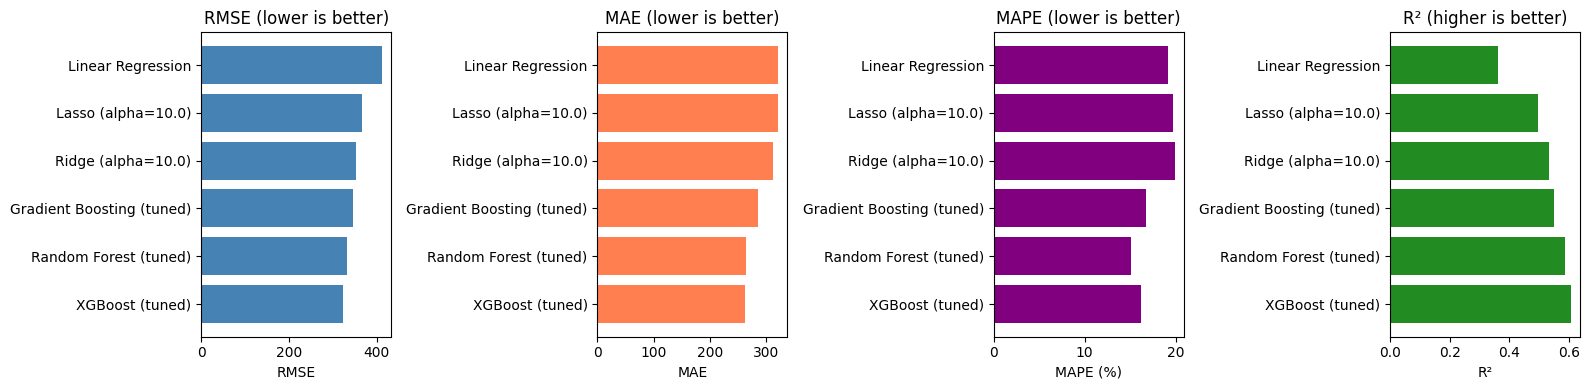

In [22]:
# Visualize comparison
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# RMSE
axes[0].barh(results_df['Model'], results_df['RMSE'], color='steelblue')
axes[0].set_xlabel('RMSE')
axes[0].set_title('RMSE (lower is better)')

# MAE
axes[1].barh(results_df['Model'], results_df['MAE'], color='coral')
axes[1].set_xlabel('MAE')
axes[1].set_title('MAE (lower is better)')

# MAPE
axes[2].barh(results_df['Model'], results_df['MAPE'], color='purple')
axes[2].set_xlabel('MAPE (%)')
axes[2].set_title('MAPE (lower is better)')

# R²
axes[3].barh(results_df['Model'], results_df['R²'], color='forestgreen')
axes[3].set_xlabel('R²')
axes[3].set_title('R² (higher is better)')

plt.tight_layout()
plt.show()

## 8. Feature Importance Analysis

In [23]:
# Get best model
best_model_name = results_df.iloc[0]['Model']
print(f"Best model: {best_model_name}")

# Feature importance from Random Forest (usually most reliable)
rf_model = trained_models['Random Forest']
importance = rf_model.feature_importances_

# Sort by importance
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importance
}).sort_values('Importance', ascending=False)

print("\nRandom Forest Feature Importance:")
print(importance_df.to_string(index=False))

Best model: XGBoost (tuned)

Random Forest Feature Importance:
                Feature  Importance
opponent_avg_attendance    0.357765
               spieltag    0.152881
        games_remaining    0.116212
            weekday_sin    0.084678
           distance_log    0.063960
                   hour    0.057666
    is_christmas_period    0.045273
              month_sin    0.039037
    season_tickets_sold    0.037951
            weekday_cos    0.015783
              month_cos    0.009241
         is_late_season    0.008115
      is_school_holiday    0.007202
             is_weekend    0.002995
           near_holiday    0.001169
      is_public_holiday    0.000072


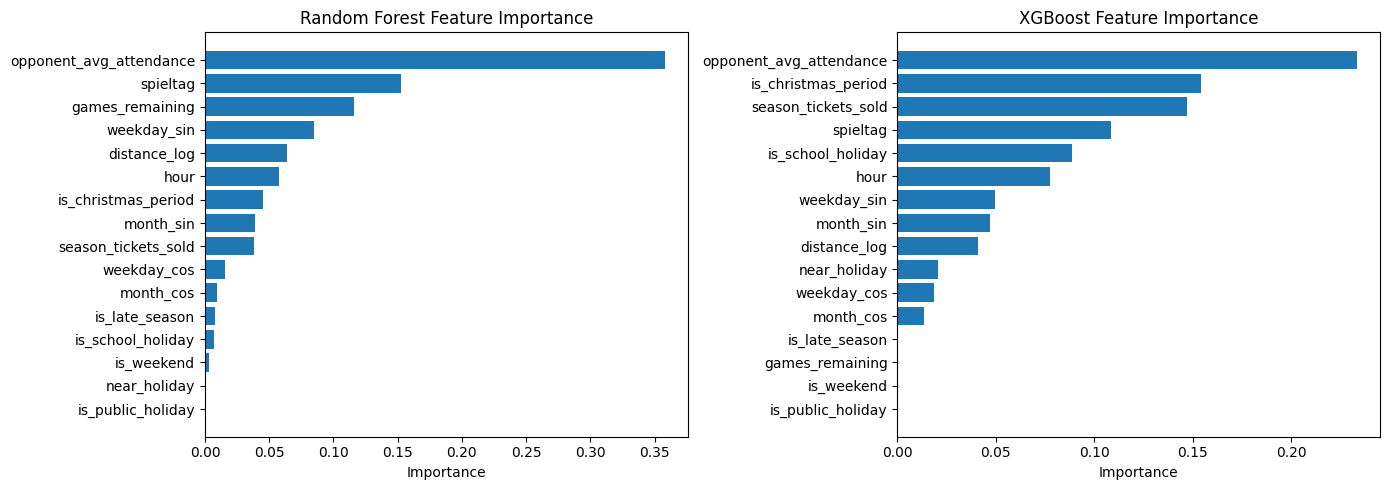

In [24]:
# Plot feature importance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Random Forest
sorted_idx = np.argsort(rf_model.feature_importances_)
axes[0].barh([feature_cols[i] for i in sorted_idx], rf_model.feature_importances_[sorted_idx])
axes[0].set_title('Random Forest Feature Importance')
axes[0].set_xlabel('Importance')

# XGBoost
xgb_model = trained_models['XGBoost']
sorted_idx = np.argsort(xgb_model.feature_importances_)
axes[1].barh([feature_cols[i] for i in sorted_idx], xgb_model.feature_importances_[sorted_idx])
axes[1].set_title('XGBoost Feature Importance')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.show()

## 9. Actual vs Predicted Analysis

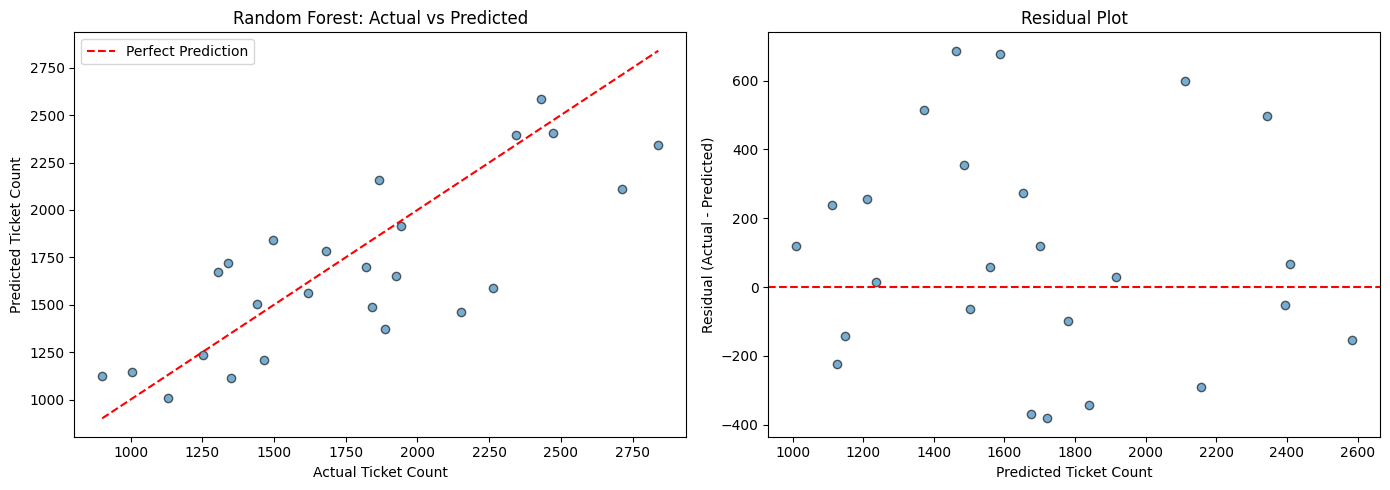


Residual Statistics:
Mean Residual: 95.53
Std Residual: 317.88
Max Over-prediction: -381.67
Max Under-prediction: 687.00


In [25]:
# Get predictions from best tree-based model
best_tree_model = trained_models['Random Forest']
y_pred_best = best_tree_model.predict(X_test.values)

# Plot actual vs predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_test, y_pred_best, alpha=0.6, edgecolor='k')
min_val = min(y_test.min(), y_pred_best.min())
max_val = max(y_test.max(), y_pred_best.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
axes[0].set_xlabel('Actual Ticket Count')
axes[0].set_ylabel('Predicted Ticket Count')
axes[0].set_title('Random Forest: Actual vs Predicted')
axes[0].legend()

# Residual plot
residuals = y_test.values - y_pred_best
axes[1].scatter(y_pred_best, residuals, alpha=0.6, edgecolor='k')
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Ticket Count')
axes[1].set_ylabel('Residual (Actual - Predicted)')
axes[1].set_title('Residual Plot')

plt.tight_layout()
plt.show()

# Residual statistics
print(f"\nResidual Statistics:")
print(f"Mean Residual: {residuals.mean():.2f}")
print(f"Std Residual: {residuals.std():.2f}")
print(f"Max Over-prediction: {residuals.min():.2f}")
print(f"Max Under-prediction: {residuals.max():.2f}")

In [26]:
# Detailed prediction analysis
prediction_analysis = test_data[['date', 'away_team', 'weekday', 'is_weekend', 
                                  'is_public_holiday', 'ticket_count']].copy()
prediction_analysis['predicted'] = y_pred_best
prediction_analysis['error'] = prediction_analysis['ticket_count'] - prediction_analysis['predicted']
prediction_analysis['abs_error'] = prediction_analysis['error'].abs()
prediction_analysis['pct_error'] = (prediction_analysis['error'] / prediction_analysis['ticket_count'] * 100).round(1)

print("\nPrediction Details (sorted by absolute error):")
print(prediction_analysis.sort_values('abs_error', ascending=False).to_string())


Prediction Details (sorted by absolute error):
         date                away_team  weekday  is_weekend  is_public_holiday  ticket_count    predicted       error   abs_error  pct_error
58 2024-11-17  Schwenninger Wild Wings        6           1                  0        2151.0  1464.002098  686.997902  686.997902       31.9
65 2024-12-22          Löwen Frankfurt        6           1                  0        2265.0  1587.735529  677.264471  677.264471       29.9
56 2024-10-20          Eisbären Berlin        6           1                  0        2712.0  2111.924095  600.075905  600.075905       22.1
67 2025-01-05         Straubing Tigers        6           1                  0        1887.0  1373.379354  513.620646  513.620646       27.2
66 2024-12-26          Eisbären Berlin        3           0                  1        2840.0  2342.209419  497.790581  497.790581       17.5
62 2024-12-06     EHC Red Bull München        4           0                  0        1339.0  1720.672126 

In [27]:
# Error analysis by category
print("\nError Analysis by Game Type:")
print("="*50)

# Weekend vs Weekday
weekend_mask = test_data['is_weekend'] == 1
print(f"\nWeekend games MAE: {np.abs(residuals[weekend_mask.values]).mean():.2f}")
print(f"Weekday games MAE: {np.abs(residuals[~weekend_mask.values]).mean():.2f}")

# Holiday vs Non-holiday
holiday_mask = test_data['near_holiday'] == 1
print(f"\nNear-holiday games MAE: {np.abs(residuals[holiday_mask.values]).mean():.2f}")
print(f"Regular games MAE: {np.abs(residuals[~holiday_mask.values]).mean():.2f}")


Error Analysis by Game Type:

Weekend games MAE: 346.46
Weekday games MAE: 200.56

Near-holiday games MAE: 341.91
Regular games MAE: 254.24


## 10. Save Outputs

In [28]:
import os

# Create output directory
output_dir = 'Models/baseline_model_v3'
os.makedirs(output_dir, exist_ok=True)

# Save best model
best_model = trained_models['XGBoost']
model_path = f'{output_dir}/best_model_xgboost_v3.joblib'
joblib.dump(best_model, model_path)
print(f"Saved best model to {model_path}")

best_model = trained_models['Random Forest']
model_path = f'{output_dir}/2nd_best_model_random_forest_v3.joblib'
joblib.dump(best_model, model_path)
print(f"Saved RF model to {model_path}")

# Save scaler
scaler_path = f'{output_dir}/feature_scaler_v3.joblib'
joblib.dump(scaler, scaler_path)
print(f"Saved scaler to {scaler_path}")

# Save opponent encoding
encoding_path = f'{output_dir}/opponent_encoding_v3.json'
with open(encoding_path, 'w') as f:
    json.dump(opponent_avg_train.to_dict(), f, indent=2)
print(f"Saved opponent encoding to {encoding_path}")

# Save feature list
features_path = f'{output_dir}/feature_cols_v3.json'
with open(features_path, 'w') as f:
    json.dump(feature_cols, f, indent=2)
print(f"Saved feature list to {features_path}")

# Save results
results_df.to_csv(f'{output_dir}/model_results_v3.csv', index=False)
print("Saved model comparison results")

Saved best model to Models/baseline_model_v3/best_model_xgboost_v3.joblib
Saved RF model to Models/baseline_model_v3/2nd_best_model_random_forest_v3.joblib
Saved scaler to Models/baseline_model_v3/feature_scaler_v3.joblib
Saved opponent encoding to Models/baseline_model_v3/opponent_encoding_v3.json
Saved feature list to Models/baseline_model_v3/feature_cols_v3.json
Saved model comparison results


## 11. Comparison with v2

### v2 Results (baseline):
- Random Forest: RMSE=397.22, MAE=329.83, R²=0.409

### v3 Results (enhanced features):
- XGBoost (tuned): RMSE=324.08, MAE=261.80, MAPE = 16.20, R²=0.606
- Random Forest (tuned): RMSE=331.93, MAE=264.76, MAPE = 15.05, R²=0.587

### Key Improvements:
1. Added holiday features (public holidays, school holidays, Christmas period)
2. Included season_tickets_sold as a trend indicator
3. Used cyclical encoding for month/weekday
4. Added spieltag and games_remaining features
5. Applied hyperparameter tuning for all models

### Next Steps:
1. Add external data: weather, opponent league positions
2. Try ensemble methods (stacking/blending)
3. Feature selection to reduce overfitting risk
4. Generate predictions for 25-26 season